In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/nfl_inference_server.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/nfl_gateway.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/__init__.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/generated/kaggle_evaluati

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
from tqdm.auto import tqdm
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb


In [4]:
import glob
import os

# Data Loading

In [5]:
from pathlib import Path

# Check if /kaggle/input exists to determine if running on Kaggle
if os.path.exists("/kaggle/input"):
    # On Kaggle notebook
    DATA_DIR = Path("/kaggle/input/nfl-big-data-bowl-2026-prediction")
else:
    # On local PC
    DATA_DIR = Path("nfl-big-data-bowl-2026-prediction")

# DATA_DIR = Path("nfl-big-data-bowl-2026-prediction")

# Load all CSV files from train folder
train_input_files = sorted(glob.glob(str(DATA_DIR /'train'/'input_*.csv')))
train_output_files = sorted(glob.glob(str(DATA_DIR /'train'/'output_*.csv')))

print(f'Input files: {len(train_input_files)}')
print(f'Output files: {len(train_output_files)}')

Input files: 18
Output files: 18


# Data Preprocessing

In [6]:
# Combine data
input_dfs = []
output_dfs = []

for input_file, output_file in zip(train_input_files, train_output_files):
    input_df = pd.read_csv(input_file)
    output_df = pd.read_csv(output_file)
    input_dfs.append(input_df)
    output_dfs.append(output_df)

train_input = pd.concat(input_dfs, ignore_index=True)
train_output = pd.concat(output_dfs, ignore_index=True)

print(f'Train input shape: {train_input.shape}')
print(f'Train output shape: {train_output.shape}')

Train input shape: (4880579, 23)
Train output shape: (562936, 6)


In [7]:
# Data Inspection
print("Input columns:")
print(train_input.columns.tolist())
print("\nOutput columns:")
print(train_output.columns.tolist())
print("\nInput sample:")
display(train_input.head())
print("\nOutput sample:")
display(train_output.head())

Input columns:
['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y']

Output columns:
['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y']

Input sample:


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22



Output sample:


,game_id,play_id,nfl_id,frame_id,x,y
0,2023090700,101,46137,1,56.22,17.28
1,2023090700,101,46137,2,56.63,16.88
2,2023090700,101,46137,3,57.06,16.46
3,2023090700,101,46137,4,57.48,16.02
4,2023090700,101,46137,5,57.91,15.56


In [8]:
# Filter only players to predict
train_input_filtered = train_input[train_input['player_to_predict'] == True].copy()
print(f'Filtered input shape: {train_input_filtered.shape}')

Filtered input shape: (1303440, 23)


In [9]:
# Merge input and output data
merged_data = train_input_filtered.merge(
    train_output,
    on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
    suffixes=('_input', '_output')
)

print(f'Merged data shape: {merged_data.shape}')

# --- Start of Play Direction Standardization ---
print("Standardizing play direction...")

# Create a mask for 'left' plays
left_mask = merged_data['play_direction'] == 'left'

# Flip x coordinates (120 yard field)
merged_data.loc[left_mask, 'x_input'] = 120.0 - merged_data.loc[left_mask, 'x_input']
merged_data.loc[left_mask, 'ball_land_x'] = 120.0 - merged_data.loc[left_mask, 'ball_land_x']
merged_data.loc[left_mask, 'x_output'] = 120.0 - merged_data.loc[left_mask, 'x_output'] # Flip target

# Flip y coordinates (53.3 yard field width)
merged_data.loc[left_mask, 'y_input'] = 53.3 - merged_data.loc[left_mask, 'y_input']
merged_data.loc[left_mask, 'ball_land_y'] = 53.3 - merged_data.loc[left_mask, 'ball_land_y']
merged_data.loc[left_mask, 'y_output'] = 53.3 - merged_data.loc[left_mask, 'y_output'] # Flip target

# Flip orientation and direction angles
merged_data.loc[left_mask, 'o'] = (merged_data.loc[left_mask, 'o'] + 180) % 360
merged_data.loc[left_mask, 'dir'] = (merged_data.loc[left_mask, 'dir'] + 180) % 360

print("Play direction standardized. All plays now effectively move 'right'.")
# --- End of Play Direction Standardization ---

display(merged_data.head())

Merged data shape: (560426, 25)
Standardizing play direction...
Play direction standardized. All plays now effectively move 'right'.


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,y_input,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,x_output,y_output
0,2023090700,101,True,46137,1,right,42,Justin Reid,6-1,204,...,20.69,0.31,0.49,79.43,267.68,21,63.259998,-0.22,56.22,17.28
1,2023090700,101,True,46137,2,right,42,Justin Reid,6-1,204,...,20.66,0.36,0.74,118.07,268.66,21,63.259998,-0.22,56.63,16.88
2,2023090700,101,True,46137,3,right,42,Justin Reid,6-1,204,...,20.63,0.44,0.76,130.89,269.78,21,63.259998,-0.22,57.06,16.46
3,2023090700,101,True,46137,4,right,42,Justin Reid,6-1,204,...,20.61,0.48,0.62,134.50,269.78,21,63.259998,-0.22,57.48,16.02
4,2023090700,101,True,46137,5,right,42,Justin Reid,6-1,204,...,20.58,0.54,0.44,129.79,269.06,21,63.259998,-0.22,57.91,15.56


# Feature selection 

In [10]:
# --- Start of Feature Engineering ---

# 1. Convert Player Height to Inches
def height_to_inches(height_str):
    try:
        # Convert to string first to handle potential non-string inputs
        feet, inches = str(height_str).split('-')
        return int(feet) * 12 + int(inches)
    except:
        return np.nan # Return NaN for any parsing errors

merged_data['player_height'] = merged_data['player_height'].apply(height_to_inches)

# 2. Calculate BMI
# We need height in meters and weight in kilograms
height_m = merged_data['player_height'] * 0.0254  # inches to meters
weight_kg = merged_data['player_weight'] * 0.453592 # lbs to kg
merged_data['bmi'] = weight_kg / (height_m ** 2) #bmi

# 3. Calculate Age (using game_id and birth_date)
try:
    # Extract year from game_id and birth year from player_birth_date
    merged_data['game_year'] = merged_data['game_id'].astype(str).str[:4].astype(int)
    merged_data['birth_year'] = pd.to_datetime(merged_data['player_birth_date']).dt.year
    
    # Calculate age
    merged_data['age'] = merged_data['game_year'] - merged_data['birth_year']
    
    # Drop the temporary helper columns
    merged_data = merged_data.drop(columns=['game_year', 'birth_year'])
    
except Exception as e:
    print(f"Warning: Could not calculate age. Error: {e}")
    print("This likely means 'game_id' or 'player_birth_date' is missing or in an invalid format.")
    merged_data['age'] = np.nan # Create 'age' column with NaN values

# 4. Calculate Vector, Distance, and Angle to Ball
# We use 'x_input', 'y_input', and 'dir' as the player's starting state
merged_data['vec_x_to_ball'] = merged_data['ball_land_x'] - merged_data['x_input']
merged_data['vec_y_to_ball'] = merged_data['ball_land_y'] - merged_data['y_input']

# Calculate distance
merged_data['dist_to_ball'] = np.sqrt(
    merged_data['vec_x_to_ball']**2 + merged_data['vec_y_to_ball']**2
)

# Calculate angle to ball (counter-clockwise from positive X-axis)
angle_to_ball_rad = np.arctan2(
    merged_data['vec_y_to_ball'], merged_data['vec_x_to_ball']
)
angle_to_ball_deg = np.degrees(angle_to_ball_rad)

# Convert angle to NFL 'dir' standard (clockwise from positive Y-axis [0, 360])
merged_data['angle_to_ball'] = (450 - angle_to_ball_deg) % 360

# Calculate the smallest angle between player's direction and angle to ball
angle_diff = np.abs(merged_data['dir'] - merged_data['angle_to_ball'])
merged_data['diff_dir_ball_angle'] = np.min(
    np.stack([angle_diff, 360 - angle_diff], axis=0), axis=0
)

# --- End of Feature Engineering ---


# Feature Selection
feature_columns = [
    'absolute_yardline_number',
    'player_height',
    'player_weight',
    'x_input',  # Current x coordinate
    'y_input',  # Current y coordinate
    's',  # Speed
    'a',  # Acceleration
    'dir',  # Direction
    'o',  # Orientation
    'num_frames_output',  # Number of frames to predict
    'ball_land_x',  # Ball landing x
    'ball_land_y',  # Ball landing y
    
    # --- New Features ---
    'bmi',                  # Body Mass Index
    'age',                  # Player age
    'vec_x_to_ball',        # Vector from player to ball (x-component)
    'vec_y_to_ball',        # Vector from player to ball (y-component)
    'dist_to_ball',         # Distance from player to ball
    'angle_to_ball',        # Angle from player to ball (NFL standard)
    'diff_dir_ball_angle'   # Angle difference between 'dir' and 'angle_to_ball'
]


# One-hot encode player_position and player_role
position_dummies = pd.get_dummies(merged_data['player_position'], prefix='position')
role_dummies = pd.get_dummies(merged_data['player_role'], prefix='role')

merged_data = pd.concat([merged_data, position_dummies, role_dummies], axis=1)
feature_columns.extend(position_dummies.columns.tolist())
feature_columns.extend(role_dummies.columns.tolist())

# player_heightConvert to numeric(e.g., "6-1" -> 73 inches)
def height_to_inches(height_str):
    try:
        feet, inches = height_str.split('-')
        return int(feet) * 12 + int(inches)
    except:
        return np.nan

merged_data['player_height'] = merged_data['player_height'].apply(height_to_inches)

# Handle missing values
X = merged_data[feature_columns].fillna(0)
y_x = merged_data['x_output']
y_y = merged_data['y_output']

print(f'Features shape: {X.shape}')
print(f'Target X shape: {y_x.shape}')
print(f'Target Y shape: {y_y.shape}')

Features shape: (560426, 38)
Target X shape: (560426,)
Target Y shape: (560426,)


# Data Split for training and testing

In [11]:
# Split into training and test data
# y_trainConvert to 2D array (predict x, y coordinates simultaneously)
y = np.column_stack([y_x, y_y])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Target shape: {y_train.shape} (samples, [x, y])')

Training set size: 392298
Test set size: 168128
Target shape: (392298, 2) (samples, [x, y])


# Model Training

In [12]:
lgbm_nfl = LGBMRegressor(n_estimators=100,
                         random_state=0, n_jobs=-1)
multi_output_booster = MultiOutputRegressor(estimator=lgbm_nfl)
multi_output_booster.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3898
[LightGBM] [Info] Number of data points in the train set: 392298, number of used features: 35
[LightGBM] [Info] Start training from score 69.429654
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3898
[LightGBM] [Info] Number of data points in the train set: 392298, number of used features: 35
[LightGBM] [Info] Start training from score 26.509836


MultiOutputRegressor(estimator=LGBMRegressor(n_jobs=-1, random_state=0))

# Model Evaluation : Assessing Test and Training Data

In [13]:
# Predict on training and test data
y_hat_train = multi_output_booster.predict(X_train)
y_hat_test = multi_output_booster.predict(X_test)

# Calculate MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(f"Training Mean Squared Error (MSE): {train_mse}")
print(f"Test Mean Squared Error (MSE): {test_mse}")

# You can also calculate MSE per output (x and y)
train_mse_x = mean_squared_error(y_train[:, 0], y_hat_train[:, 0])
train_mse_y = mean_squared_error(y_train[:, 1], y_hat_train[:, 1])
test_mse_x = mean_squared_error(y_test[:, 0], y_hat_test[:, 0])
test_mse_y = mean_squared_error(y_test[:, 1], y_hat_test[:, 1])

print(f"\nTest MSE for X: {test_mse_x}")
print(f"Test MSE for Y: {test_mse_y}")

Training Mean Squared Error (MSE): 12.27119337202176
Test Mean Squared Error (MSE): 12.51569647303227

Test MSE for X: 12.046464639292054
Test MSE for Y: 12.984928306772353


# Importance of features

In [14]:
# 1. Extract the feature importances from each fitted LGBM model
all_importances = [
    estimator.feature_importances_ for estimator in multi_output_booster.estimators_
]

# 2. Average the importances from the 'x' model and 'y' model
average_importances = np.mean(all_importances, axis=0)

# 3. Create the DataFrame using the averaged importances
feature_names = X_train.columns.tolist()
feature_imp = pd.DataFrame(
    {'importance': average_importances},
    index=feature_names
)

# 4. Sort and display the results
print(feature_imp.sort_values(by='importance', ascending=False))

                          importance
num_frames_output              344.5
dir                            313.5
ball_land_y                    264.5
s                              234.0
y_input                        232.0
ball_land_x                    229.0
x_input                        213.5
vec_x_to_ball                  134.0
dist_to_ball                   131.5
vec_y_to_ball                  109.5
player_weight                  104.0
role_Defensive Coverage         97.5
bmi                             96.0
o                               94.0
absolute_yardline_number        79.0
a                               75.5
angle_to_ball                   69.5
position_CB                     51.5
age                             36.0
diff_dir_ball_angle             25.0
position_WR                     11.5
position_OLB                    10.0
position_FS                      9.5
position_SS                      9.5
position_ILB                     8.0
position_MLB                     8.0
p

In [15]:
y_hat_boost = multi_output_booster.predict(X_test)

mse = np.mean((y_test - y_hat_boost)**2)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 12.515696473032204


# Data Visualisation of One tree

<Figure size 2500x2000 with 0 Axes>

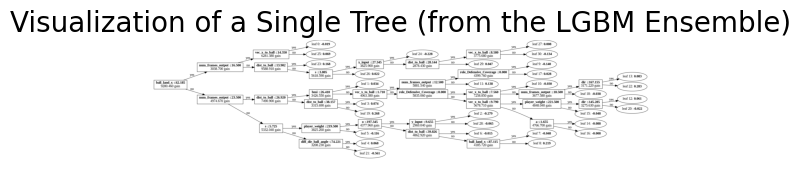

In [16]:

# 1. Get the LGBM model for the first output (the x-coordinate)
lgbm_for_first_output = multi_output_booster.estimators_[0]

# 2. Use lgb.plot_tree() to visualize one of the trees.
#    Let's plot the 50th tree (tree_index=49).
#    Note: LGBM models are sequential, so later trees can be interesting.
plt.figure(figsize=(25, 20))
lgb.plot_tree(lgbm_for_first_output, 
              tree_index=49,  # Pick which tree from the sequence to plot
              show_info=['split_gain'],
              precision=3)

plt.title("Visualization of a Single Tree (from the LGBM Ensemble)", fontsize=20)
plt.show()

# Submission

In [17]:
# --- Imports and API setup ---
import os
import pandas as pd
import polars as pl
import sys
from pathlib import Path

# 1. Add the evaluation API to the system path
# (Uses the DATA_DIR variable you defined in your "Data Loading" cell)
EVAL_DIR = DATA_DIR / 'kaggle_evaluation'
if str(EVAL_DIR) not in sys.path:
    sys.path.append(str(EVAL_DIR))

# Now these imports will work
import kaggle_evaluation.nfl_inference_server

# --- Prediction Function ---

def predict(test: pl.DataFrame, test_input: pl.DataFrame) -> pl.DataFrame | pd.DataFrame:
    """
    Generates predictions for the test set.
    This function is called by the evaluation API and must return a
    DataFrame in the submission format.
    
    It uses the globally trained 'multi_output_booster', 'feature_columns',
    'position_dummies', 'role_dummies', and 'height_to_inches'.
    """
    print("API: Received prediction request...")
    
    # --- Convert Polars to Pandas ---
    # Your model and logic use pandas, so we convert the inputs
    test_input_df = test_input.to_pandas()
    test_df = test.to_pandas()
    
    # 1. Filter only players to predict
    test_input_filtered = test_input_df[test_input_df['player_to_predict'] == True].copy()

    # 2. Rename columns to match training/feature engineering expectations
    test_input_filtered = test_input_filtered.rename(columns={'x': 'x_input', 'y': 'y_input'})

    # 3. Standardize play direction
    # Flip all 'left' plays so they look like 'right' plays
    print("API: Standardizing play direction...")
    left_mask_test = test_input_filtered['play_direction'] == 'left'
    
    # Flip x coordinates
    test_input_filtered.loc[left_mask_test, 'x_input'] = 120.0 - test_input_filtered.loc[left_mask_test, 'x_input']
    test_input_filtered.loc[left_mask_test, 'ball_land_x'] = 120.0 - test_input_filtered.loc[left_mask_test, 'ball_land_x']
    # Flip y coordinates
    test_input_filtered.loc[left_mask_test, 'y_input'] = 53.3 - test_input_filtered.loc[left_mask_test, 'y_input']
    test_input_filtered.loc[left_mask_test, 'ball_land_y'] = 53.3 - test_input_filtered.loc[left_mask_test, 'ball_land_y']
    # Flip orientation and direction angles
    test_input_filtered.loc[left_mask_test, 'o'] = (test_input_filtered.loc[left_mask_test, 'o'] + 180) % 360
    test_input_filtered.loc[left_mask_test, 'dir'] = (test_input_filtered.loc[left_mask_test, 'dir'] + 180) % 360

    # 4. Feature Engineering (must match training data)
    print("API: Performing feature engineering...")
    
    # Convert player_height to numeric (uses global 'height_to_inches' function)
    test_input_filtered['player_height'] = test_input_filtered['player_height'].apply(height_to_inches)
    
    # Calculate BMI
    height_m_test = test_input_filtered['player_height'] * 0.0254
    weight_kg_test = test_input_filtered['player_weight'] * 0.453592
    test_input_filtered['bmi'] = weight_kg_test / (height_m_test ** 2)
    
    # Calculate Age
    try:
        test_input_filtered['game_year'] = test_input_filtered['game_id'].astype(str).str[:4].astype(int)
        test_input_filtered['birth_year'] = pd.to_datetime(test_input_filtered['player_birth_date']).dt.year
        test_input_filtered['age'] = test_input_filtered['game_year'] - test_input_filtered['birth_year']
        test_input_filtered = test_input_filtered.drop(columns=['game_year', 'birth_year'])
    except Exception as e:
        print(f"API Warning: Could not calculate age. Error: {e}")
        test_input_filtered['age'] = np.nan # Create 'age' column with NaN values
        
    # Calculate Vector, Distance, and Angle to Ball
    test_input_filtered['vec_x_to_ball'] = test_input_filtered['ball_land_x'] - test_input_filtered['x_input']
    test_input_filtered['vec_y_to_ball'] = test_input_filtered['ball_land_y'] - test_input_filtered['y_input']
    test_input_filtered['dist_to_ball'] = np.sqrt(
        test_input_filtered['vec_x_to_ball']**2 + test_input_filtered['vec_y_to_ball']**2)
    angle_to_ball_rad_test = np.arctan2(
        test_input_filtered['vec_y_to_ball'], test_input_filtered['vec_x_to_ball'])
    angle_to_ball_deg_test = np.degrees(angle_to_ball_rad_test)
    test_input_filtered['angle_to_ball'] = (450 - angle_to_ball_deg_test) % 360
    angle_diff_test = np.abs(test_input_filtered['dir'] - test_input_filtered['angle_to_ball'])
    test_input_filtered['diff_dir_ball_angle'] = np.min(
        np.stack([angle_diff_test, 360 - angle_diff_test], axis=0), axis=0)

    # 5. One-hot encode player_position and player_role
    print("API: Aligning dummy variable columns...")
    test_position_dummies = pd.get_dummies(test_input_filtered['player_position'], prefix='position')
    test_role_dummies = pd.get_dummies(test_input_filtered['player_role'], prefix='role')
    
    # Align dummy columns with training data
    # (Relies on 'position_dummies' and 'role_dummies' from training being in global scope)
    for col in position_dummies.columns:
        if col not in test_position_dummies.columns:
            test_position_dummies[col] = 0
    test_position_dummies = test_position_dummies[position_dummies.columns] # Ensure same order
    
    for col in role_dummies.columns:
        if col not in test_role_dummies.columns:
            test_role_dummies[col] = 0
    test_role_dummies = test_role_dummies[role_dummies.columns] # Ensure same order
    
    # 6. Concatenate final features
    test_features = pd.concat([test_input_filtered, test_position_dummies, test_role_dummies], axis=1)

    # 7. Feature selection (using the same 'feature_columns' list from training)
    # This list MUST include all your new features ('bmi', 'age', 'dist_to_ball', etc.)
    X_test_api = test_features[feature_columns].fillna(0)
    print(f'API: Test features shape: {X_test_api.shape}')

    # 8. Predict on test data
    print('API: Predicting test data...')
    # Uses the globally trained 'multi_output_booster'
    test_predictions = multi_output_booster.predict(X_test_api)
    test_pred_x = test_predictions[:, 0]
    test_pred_y = test_predictions[:, 1]
    
    # Add predictions to test_input_filtered
    test_input_filtered['pred_x'] = test_pred_x
    test_input_filtered['pred_y'] = test_pred_y

    # 9. Invert predictions for 'left' plays
    # Use the same mask created during test data processing
    print("API: Inverting predictions for 'left' plays back to original coordinates...")
    test_input_filtered.loc[left_mask_test, 'pred_x'] = 120.0 - test_input_filtered.loc[left_mask_test, 'pred_x']
    test_input_filtered.loc[left_mask_test, 'pred_y'] = 53.3 - test_input_filtered.loc[left_mask_test, 'pred_y']
    print("API: Inversion complete.")

    # 10. Format the submission
    # Create ID matching test.csv format (needed for merging)
    submission = test_df.copy()
    submission['id'] = submission['game_id'].astype(str) + '_' + \
                       submission['play_id'].astype(str) + '_' + \
                       submission['nfl_id'].astype(str) + '_' + \
                       submission['frame_id'].astype(str)
                       
    # Merge predictions
    test_pred_df = test_input_filtered[['game_id', 'play_id', 'nfl_id', 'frame_id', 'pred_x', 'pred_y']].copy()
    
    submission = submission.merge(
        test_pred_df,
        on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
        how='left'
    )
    
    # --- FIX: Return only 'x' and 'y' columns ---
    # The gateway handles 'id' mapping. Do NOT include it.
    predictions_df = submission[['pred_x', 'pred_y']].rename(columns={'pred_x': 'x', 'pred_y': 'y'})
    
    # Fill missing values with 0 (as precaution)
    predictions_df = predictions_df.fillna(0)
    
    print("API: Prediction request complete.")
    
    # Check assertions
    assert isinstance(predictions_df, (pd.DataFrame, pl.DataFrame))
    assert len(predictions_df) == len(test_df)
    
    # Return the DataFrame with *only* x and y
    return predictions_df

# --- Server Setup ---
# This code sets up and runs the server
inference_server = kaggle_evaluation.nfl_inference_server.NFLInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    print("Starting server for competition reruns...")
    inference_server.serve()
else:
    # This runs the local gateway for testing
    print("Running local gateway for testing...")
    inference_server.run_local_gateway((f'{DATA_DIR}',)) # Pass the DATA_DIR as the path

print("Submission process finished.")

Running local gateway for testing...
API: Received prediction request...
API: Standardizing play direction...
API: Performing feature engineering...
API: Aligning dummy variable columns...
API: Test features shape: (45, 38)
API: Predicting test data...
API: Inverting predictions for 'left' plays back to original coordinates...
API: Inversion complete.
API: Prediction request complete.
API: Received prediction request...
API: Standardizing play direction...
API: Performing feature engineering...
API: Aligning dummy variable columns...
API: Test features shape: (66, 38)
API: Predicting test data...
API: Inverting predictions for 'left' plays back to original coordinates...
API: Inversion complete.
API: Prediction request complete.
API: Received prediction request...
API: Standardizing play direction...
API: Performing feature engineering...
API: Aligning dummy variable columns...
API: Test features shape: (84, 38)
API: Predicting test data...
API: Inverting predictions for 'left' plays b